In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np

from utils.conn_data import load_pickle
from utils.diagnostics import compute_summary_statistics

plt.style.use('ggplot')

In [3]:
inputs_path = os.path.join(os.getcwd(), "data", "inputs")
outputs_path = os.path.join(os.getcwd(), "data", "outputs")
forecast_input = "wrds_etf_returns"
memory_input = "fredmd_transf"
vol_target = 0.15
portfolio_methods = ["naive",
                     #"weighted-naive",
                     "linear-ridge",
                     ]

In [6]:
# load memory data and preprocess
memory_data = pd.read_csv(os.path.join(inputs_path, f'{memory_input}.csv'))

## fix dates
memory_data["date"] = pd.to_datetime(memory_data["date"])
memory_data = memory_data.set_index("date")
memory_data = memory_data.astype(float)

# fill missing values
memory_data = memory_data.interpolate(method='linear', limit_direction='forward', axis=0)
memory_data = memory_data.ffill()
memory_data = memory_data.bfill()

## compute moving average
memory_data = memory_data.rolling(window=12).mean()

## drop missing values
memory_data = memory_data.dropna()

returns = pd.read_csv(os.path.join(inputs_path, f'{forecast_input}.csv'))
returns = returns[[col for col in returns.columns if "t+1" not in col]]

## fix dates
returns["date"] = pd.to_datetime(returns["date"])
returns["date"] = returns["date"] + pd.DateOffset(months=1)
returns = returns.set_index("date")
memory_data = memory_data.astype(float)

## resample and match memory data dates
returns = returns.resample("MS").last().ffill()
returns = pd.merge(returns, memory_data[[memory_data.columns[0]]], left_index=True, right_index=True).drop(memory_data.columns[0], axis=1)

## drop missing values
returns = returns.dropna()

In [7]:
import numpy as np
import pandas as pd

data_factors = pd.read_csv('data/inputs/fredmd_factors_raw.csv')
transformation_codes = data_factors.iloc[0]
data_factors = data_factors.drop(0)
transformation_codes = transformation_codes.to_dict()
del transformation_codes['sasdate']

small = 1e-6
for column in data_factors.columns:
    if column in transformation_codes:
        match int(transformation_codes[column]):
            case 1:
                data_factors[column] = data_factors[column]

            case 2: # First difference: x(t)-x(t-1)
                data_factors[column] = data_factors[column].diff()

            case 3: # Second difference: (x(t)-x(t-1))-(x(t-1)-x(t-2))
                data_factors[column] = data_factors[column].diff().diff()

            case 4: # Natural log: ln(x)
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)

            case 5: # First difference of natural log: ln(x)-ln(x-1)
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)
                data_factors[column] = data_factors[column].diff()

            case 6: # Second difference of natural log: (ln(x)-ln(x-1))-(ln(x-1)-ln(x-2))
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)
                data_factors[column] = data_factors[column].diff().diff()

            case 7: # First difference of percent change: (x(t)/x(t-1)-1)-(x(t-1)/x(t-2)-1)
                data_factors[column] = data_factors[column].pct_change()
                data_factors[column] = data_factors[column].diff()

data_factors = data_factors.drop([1, 2]).reset_index(drop=True)

data_factors = data_factors.ffill()
data_factors = data_factors.fillna(0.0)

data_factors['sasdate'] = pd.to_datetime(data_factors['sasdate'], format='%m/%d/%Y')
data_factors = data_factors.rename(columns={'sasdate': 'date'})
data_factors = data_factors.set_index('date')


from sklearn.decomposition import PCA
import matplotlib.pyplot as plot

df_normalized = data_factors

# You must normalize the data before applying the fit method
df_normalized=(df_normalized - df_normalized.mean()) / df_normalized.std()
pca = PCA(n_components=df_normalized.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df_normalized.columns)
print(loadings)

DESIRE_EXPLAINED_VARIANCE = 0.95
total_explained_variance = 0.0
for i, x in enumerate(pca.explained_variance_ratio_):
    total_explained_variance += x
    if total_explained_variance >= DESIRE_EXPLAINED_VARIANCE:
        print(f"Number of components to explain {DESIRE_EXPLAINED_VARIANCE * 100}% variance: {i+1}")
        break
n_components = i+1

# Use the top n components to transform the data
pca = PCA(n_components=df_normalized.shape[1])
pca.fit(df_normalized)
df_transformed = pd.DataFrame(pca.transform(df_normalized),
columns=['PC%s' % _ for _ in range(df_normalized.shape[1])],
index=df_normalized.index)
df_transformed = df_transformed[['PC%s' % _ for _ in range(n_components)]]

print(df_transformed)

memory_data = df_transformed

                      PC0       PC1       PC2       PC3       PC4       PC5  \
RPI              0.032678 -0.047984  0.000752 -0.025343  0.063781 -0.045892   
W875RX1         -0.112550 -0.068211 -0.038119  0.032999  0.006149  0.006541   
DPCERA3M086SBEA -0.146550  0.027131 -0.060616  0.042417 -0.018647 -0.143320   
CMRMTSPLx       -0.135673 -0.008126 -0.053135  0.014012  0.024570 -0.093309   
RETAILx         -0.127633  0.065554 -0.019088  0.035344  0.000766 -0.146614   
...                   ...       ...       ...       ...       ...       ...   
UMCSENTx        -0.037855  0.012142 -0.030014 -0.014400 -0.012411 -0.098975   
DTCOLNVHFNM     -0.002451  0.009939  0.011267 -0.016205 -0.015283 -0.058104   
DTCTHFNM        -0.006255  0.013653  0.012419 -0.018355 -0.013001 -0.032122   
INVEST          -0.015517  0.016652 -0.007961  0.011221 -0.015233  0.019285   
VIXCLSx          0.052323  0.001555  0.009238  0.039914 -0.001340 -0.121704   

                      PC6       PC7       PC8      

In [8]:
# get regimes
#file_name = "results.pkl"
file_name = "results_custom_elbow.pkl"
memory_dir_name = "kmeans_elbow"
memory_results_path = os.path.join("data", "inputs", "memory", memory_dir_name, "results.pkl")
memory_results = pd.read_pickle(memory_results_path)
regimes = memory_results["regimes"]
centroids = memory_results["centroids"]
regimes_probs = memory_results["regimes_probs"]

In [9]:
for x in memory_data.columns:
    print(x)

PC0
PC1
PC2
PC3
PC4
PC5
PC6
PC7
PC8
PC9
PC10
PC11
PC12
PC13
PC14
PC15
PC16
PC17
PC18
PC19
PC20
PC21
PC22
PC23
PC24
PC25
PC26
PC27
PC28
PC29
PC30
PC31
PC32
PC33
PC34
PC35
PC36
PC37
PC38
PC39
PC40
PC41
PC42
PC43
PC44
PC45
PC46
PC47
PC48
PC49
PC50
PC51
PC52
PC53
PC54
PC55
PC56
PC57
PC58
PC59
PC60


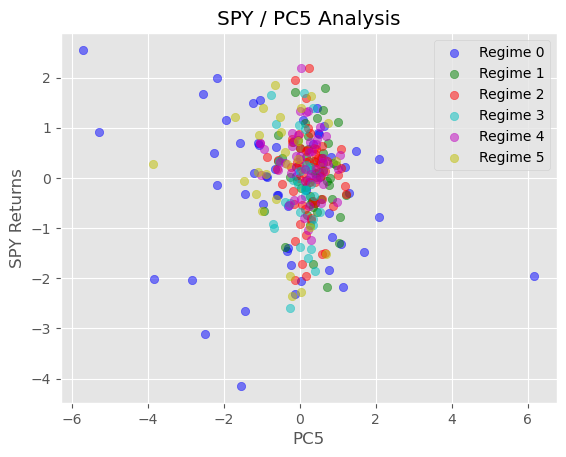

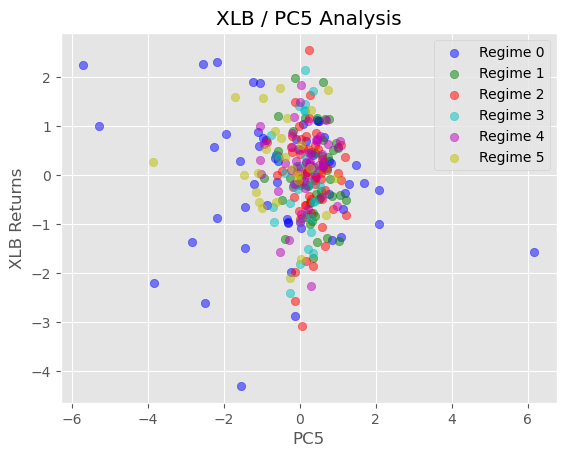

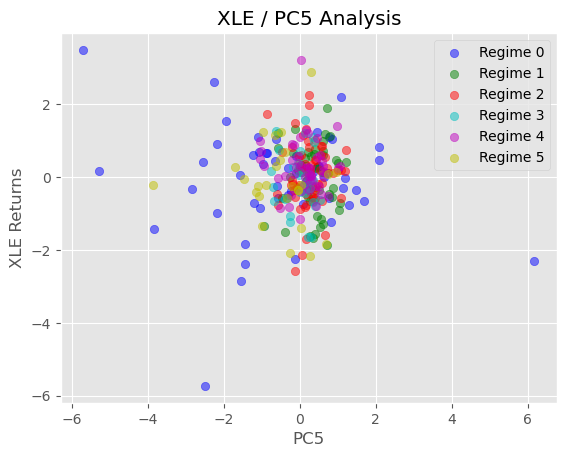

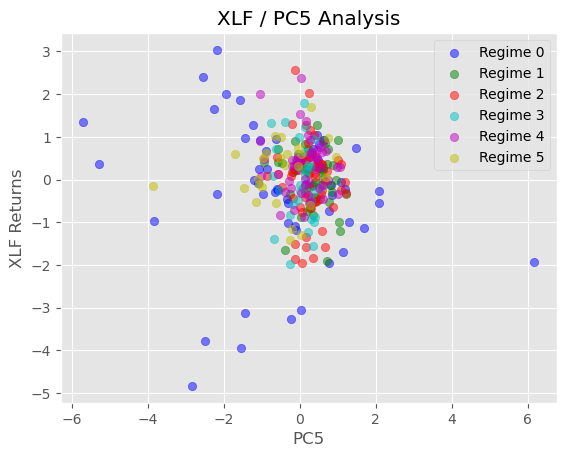

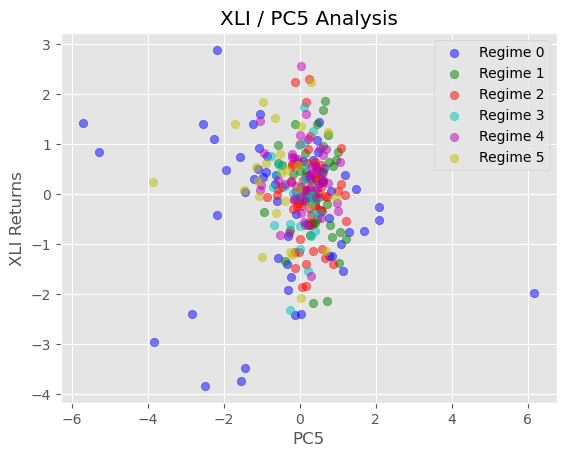

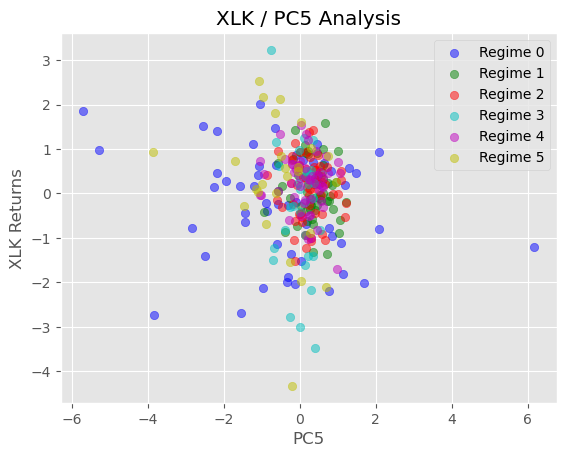

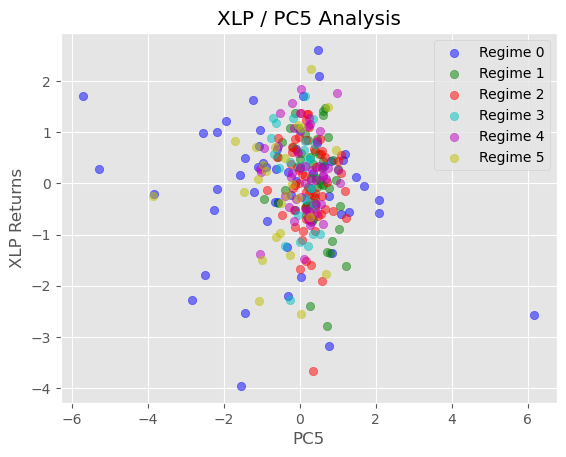

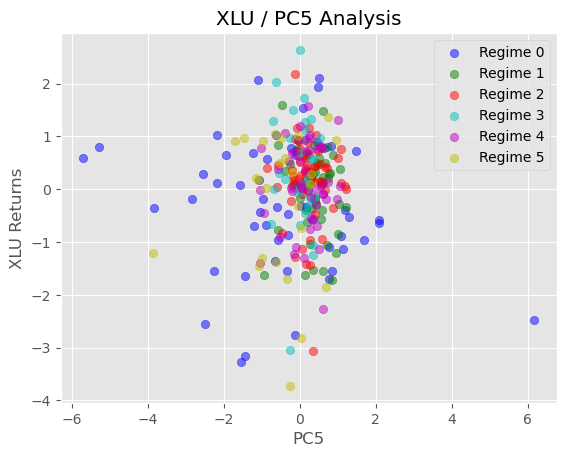

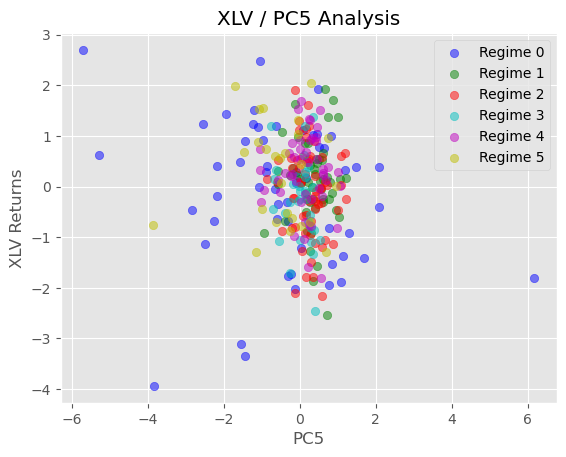

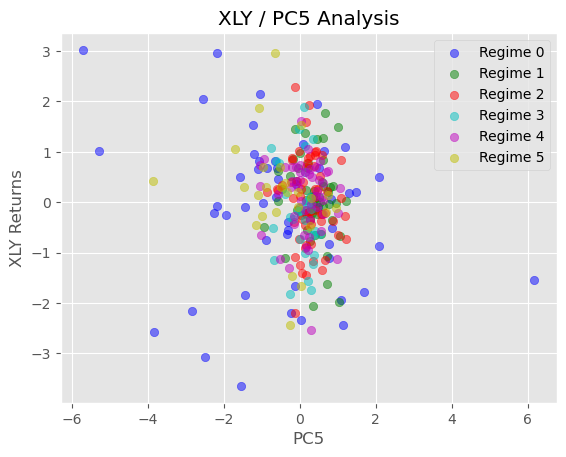

In [32]:
etfs = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
macro_var = 'PC5'

for etf in etfs:
    plt.clf()
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    for i in range(6):
        stand_returns = (returns[etf] - returns[etf].mean()) / returns[etf].std()
        stand_pc = (memory_data[-296:-21][macro_var] - memory_data[-296:-21][macro_var].mean()) / memory_data[-296:-21][macro_var].std()
        plt.scatter(stand_pc[regimes[-275:]['cluster_step697'] == i], stand_returns[regimes[-275:]['cluster_step697'] == i], c=colors[i], label=f"Regime {i}", alpha=0.5)
    plt.title(f"{etf} / {macro_var} Analysis")
    plt.xlabel(macro_var)
    plt.ylabel(etf + " Returns")
    plt.legend()
    plt.show()

In [18]:
all_portfolio_returns = []
colors = ['r', 'b', 'g', 'y', 'm', 'c', 'k']
line_types = ['-', '--', '-.', ':']
styles = ['m', 'c']
for method in portfolio_methods:
    cur_color = colors.pop(0)
    dirs = os.listdir(os.path.join(outputs_path, method))

    for i, dir in enumerate(dirs):
        cur_line_type = line_types[i % len(line_types)]
        styles.append(f"{cur_color}{cur_line_type}")
        print(dir)

        results = load_pickle(os.path.join(outputs_path, method, dir))
        
        # get forecasts
        forecasts = results['forecasts']
        forecasts.index = pd.to_datetime(forecasts.index)
        forecasts.index.name = "date"

        # check which dataframe haas the smallest number of rows and match dates
        if len(forecasts) < len(returns):
            returns = returns.loc[forecasts.index[0]:forecasts.index[-1]]
        else:
            forecasts = forecasts.loc[returns.index[0]:returns.index[-1]]

        # match columns
        for col in returns.columns:
            if col not in forecasts.columns:
                forecasts[col] = 0.0
        forecasts = forecasts[returns.columns]

        # portfolio returns
        portfolio_returns = forecasts.multiply(returns, axis=0)

        model_tag = dir.split('.')[0][8:]
        #long_only_tag = dir.split('.')[0].split('_')[1]
        #num_assets_tag = dir.split('.')[0].split('_')[2]
        portfolio_returns["models"] = f"{method}_{model_tag}"

        all_portfolio_returns.append(portfolio_returns.reset_index().melt(["models", "date"]))
all_portfolio_returns_df = pd.concat(all_portfolio_returns)

results_los_3_rand.pkl
results_mx_4.pkl
results_los_3.pkl
results_lns_3_rand.pkl
results_lns_2.pkl
results_lns_3.pkl
results_lo_2.pkl
results_lo_3.pkl
results_los_4.pkl
results_lo_4.pkl
results_mx_4.pkl
results_mx_3.pkl
results_lo_2.pkl
results_lo_4.pkl


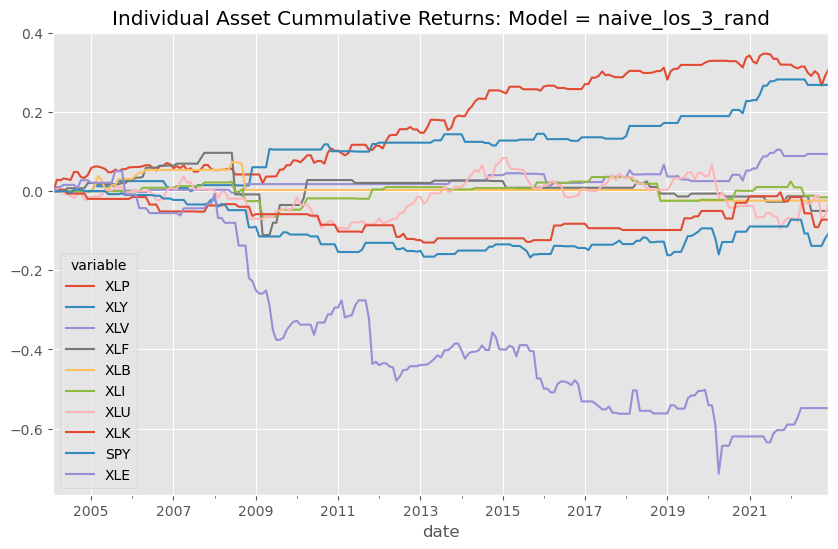

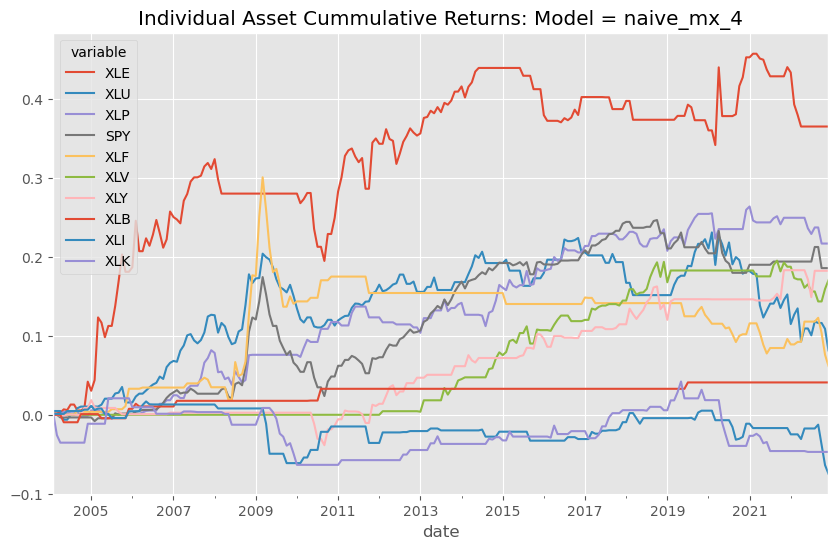

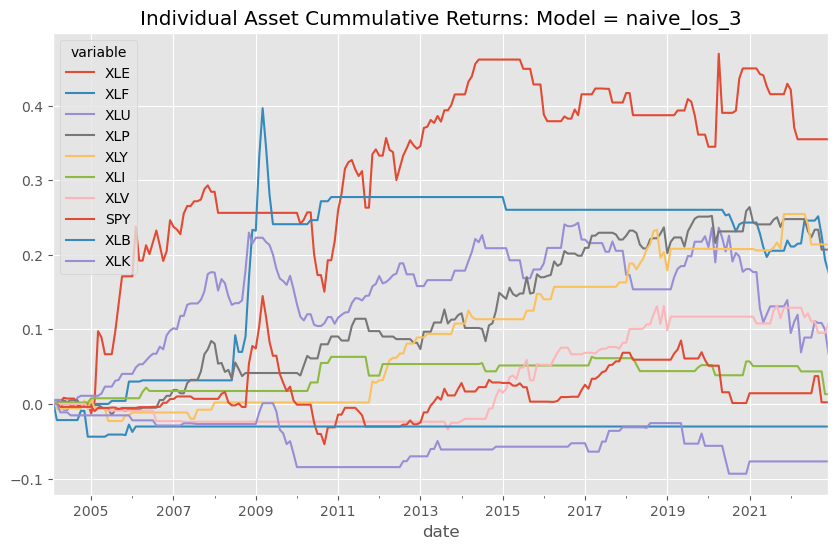

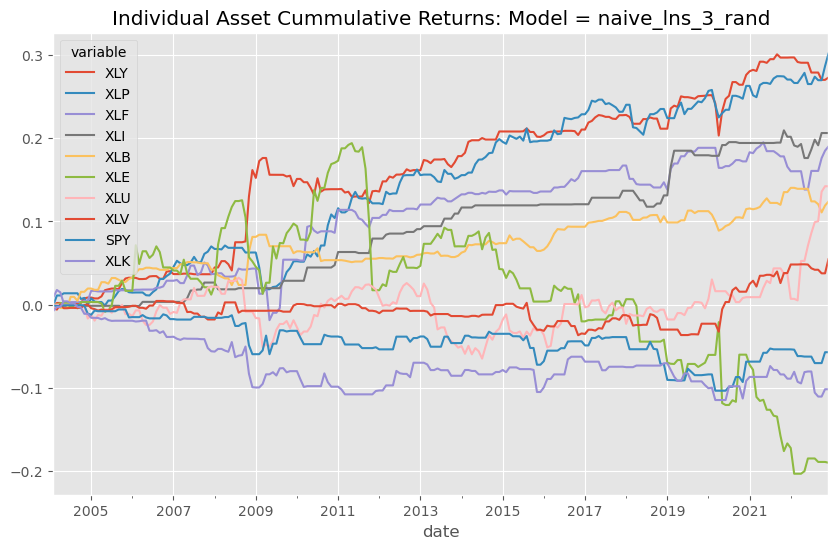

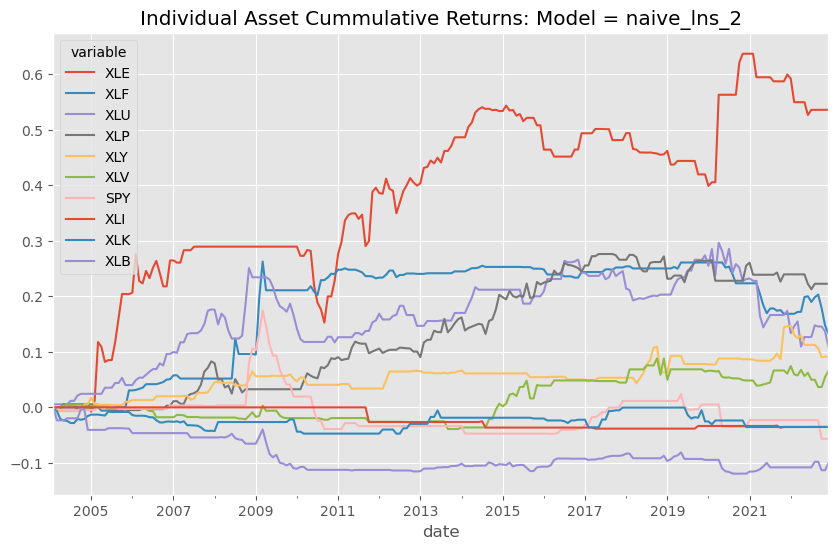

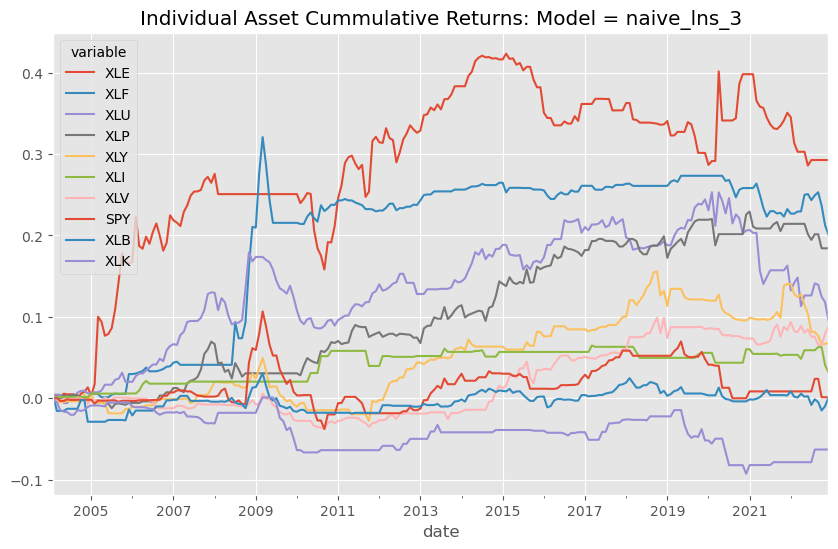

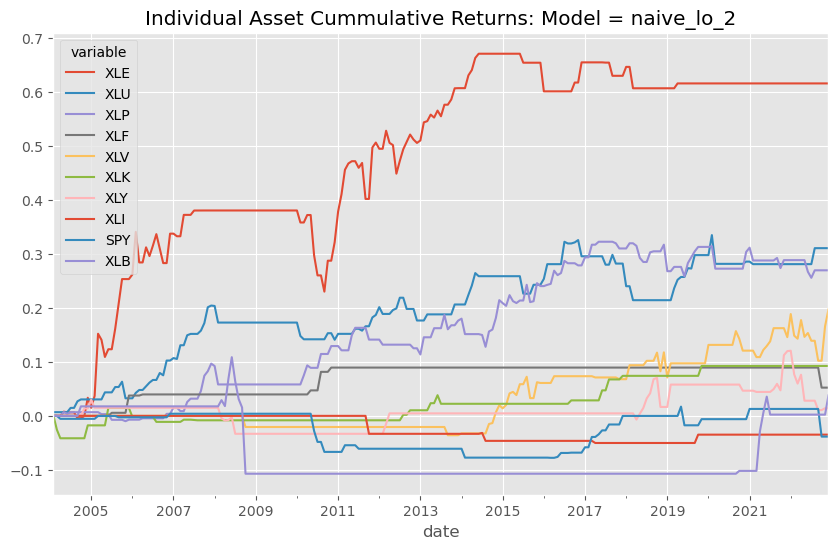

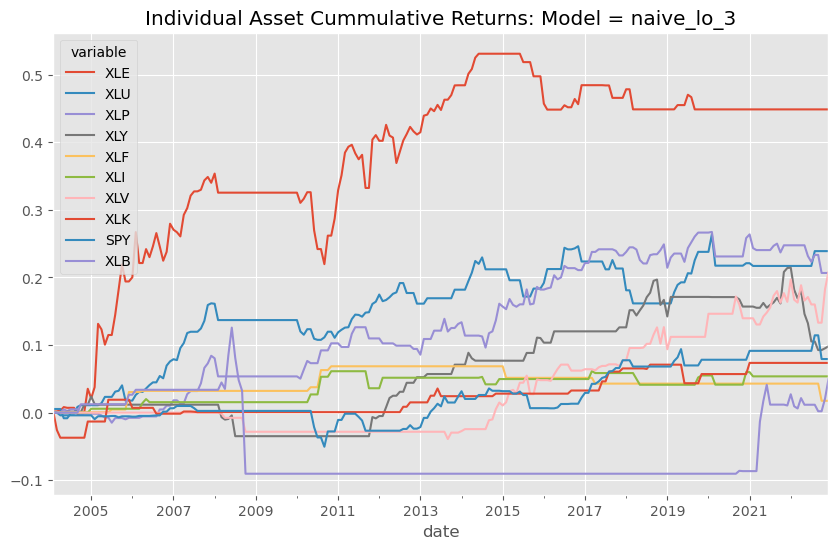

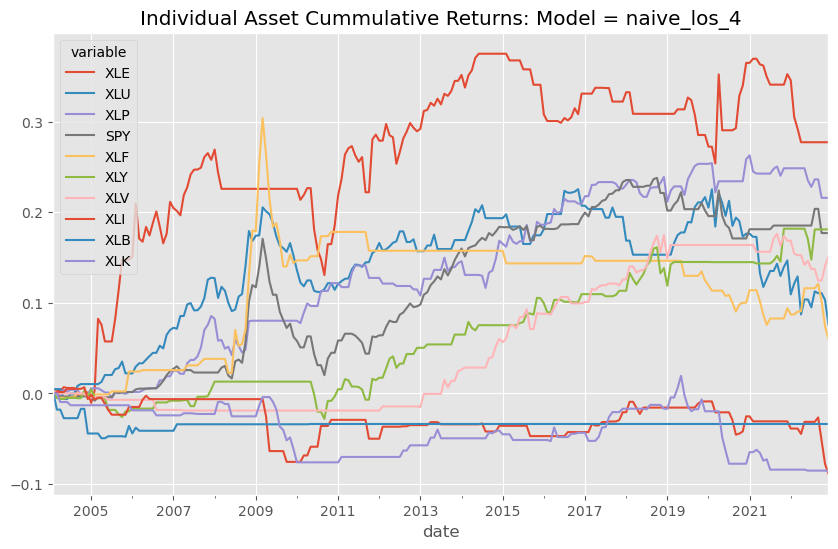

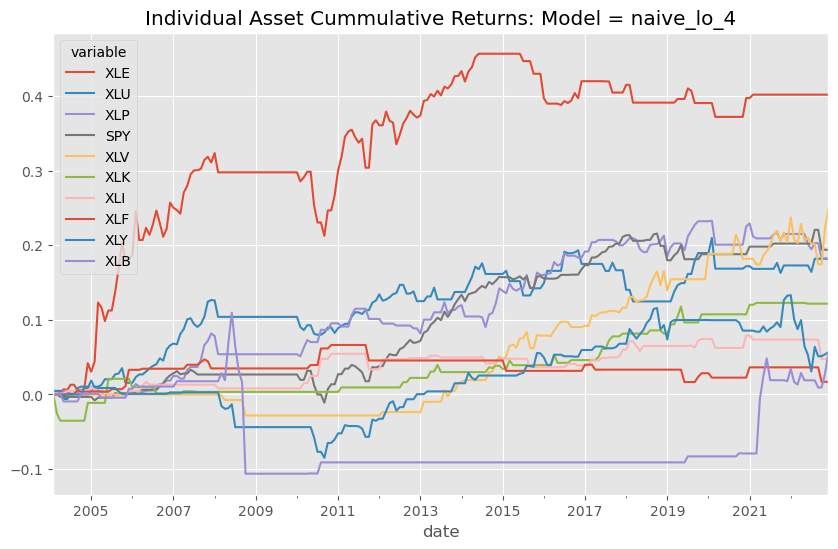

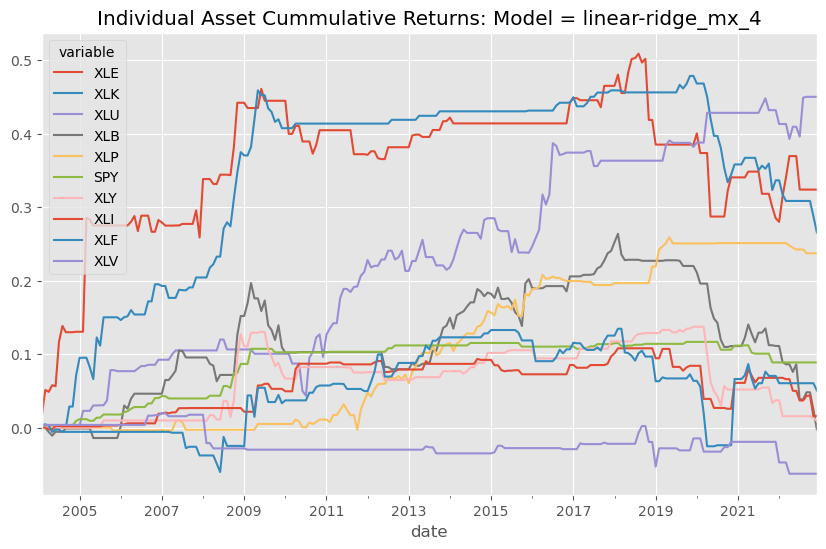

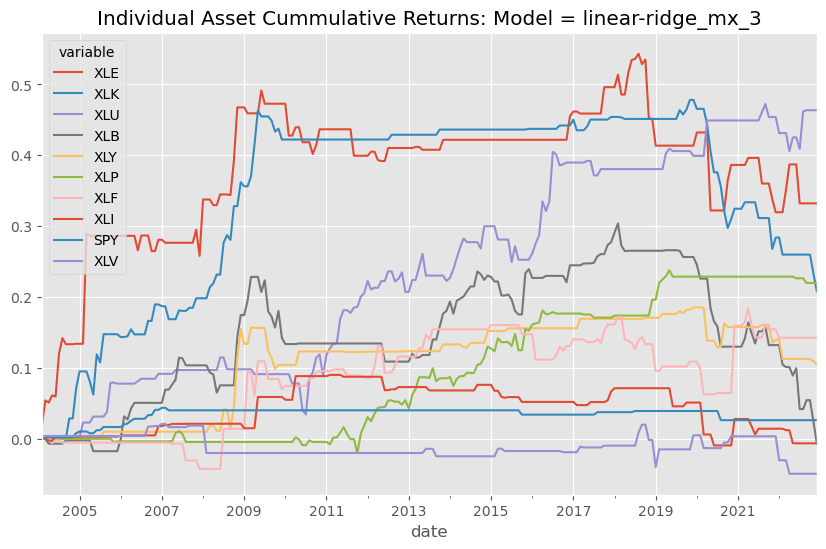

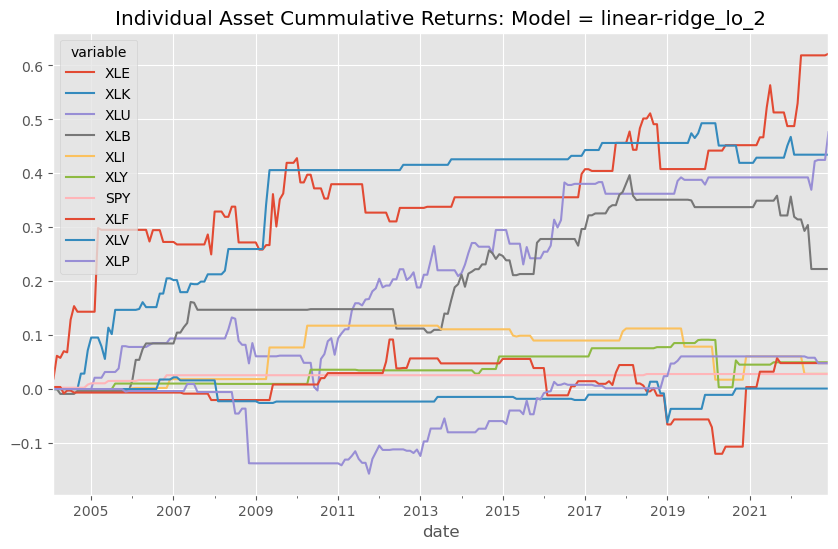

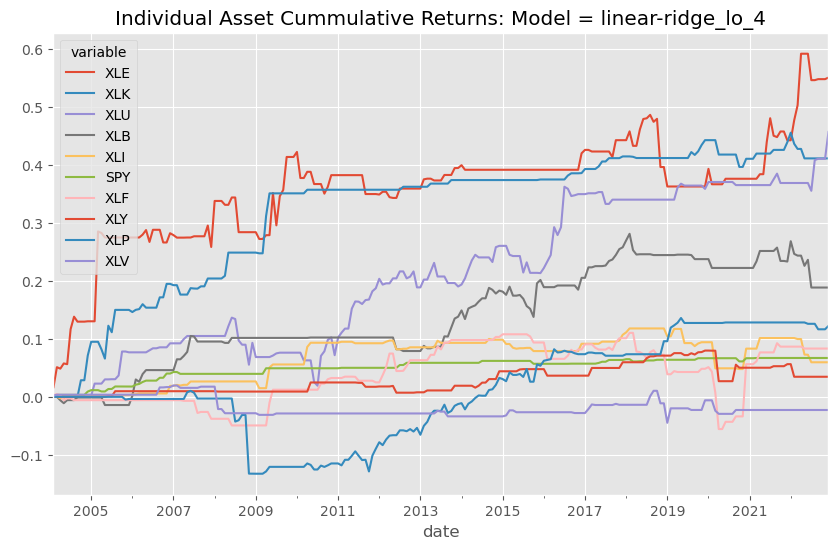

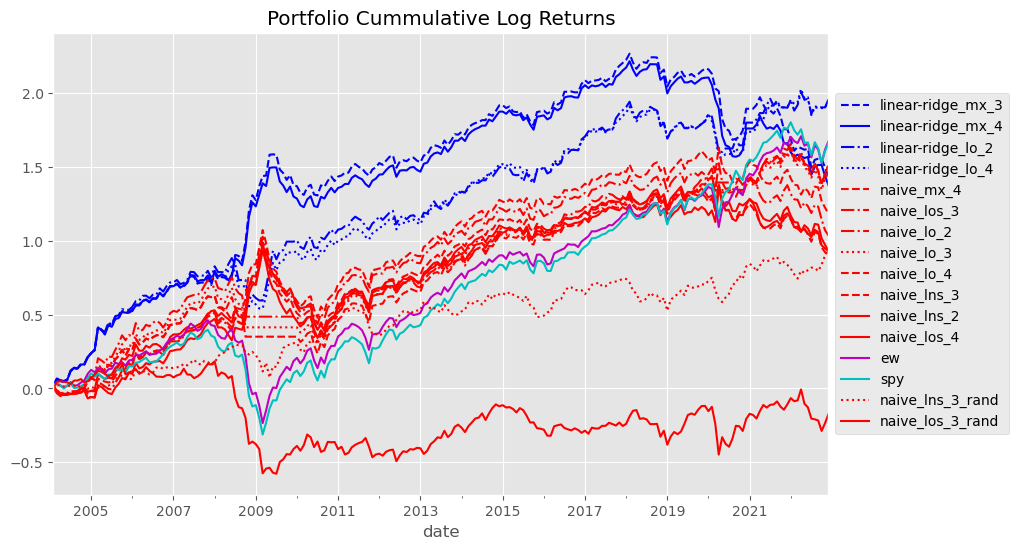

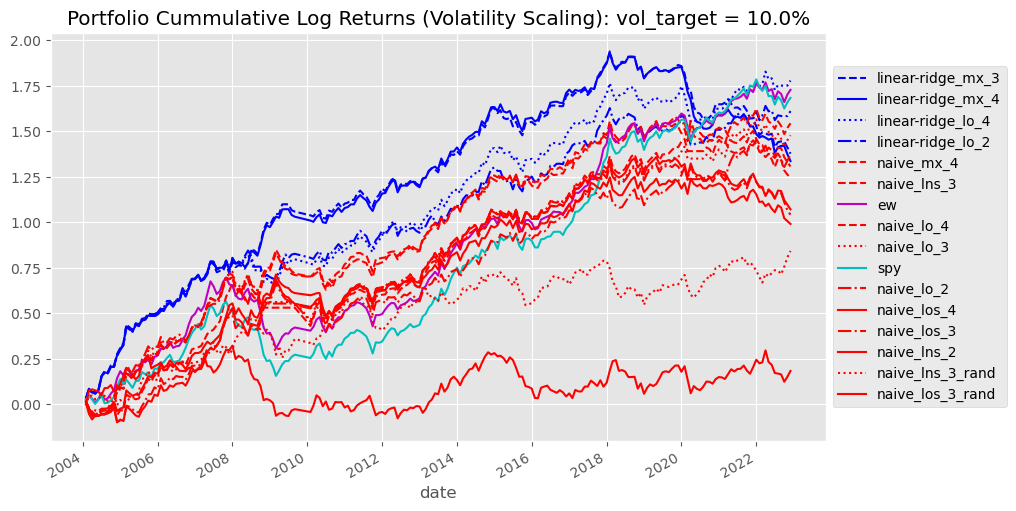

In [22]:
equal_weight_cumm_returns = pd.DataFrame(returns.mean(axis=1), columns=["ew"])
spy_cumm_returns = pd.DataFrame(pd.DataFrame(returns['SPY'], columns=["SPY"]).sum(axis=1), columns=["spy"])
concat_list = [equal_weight_cumm_returns, spy_cumm_returns]

for model in all_portfolio_returns_df["models"].unique():
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")
    order = tmp_portfolio_returns.cumsum().mean(axis=0).sort_values(ascending=False).index
    tmp_portfolio_returns.cumsum()[order].plot(figsize=(10, 6), title=f"Individual Asset Cummulative Returns: Model = {model}")
    plt.show()

    # add equal weight
    concat_list.append(pd.DataFrame(tmp_portfolio_returns.sum(axis=1), columns=[model]))
cumm_returns_plot = pd.concat(concat_list, axis=1)
order = cumm_returns_plot.cumsum().mean(axis=0).sort_values(ascending=False).index
order_style = list(cumm_returns_plot.cumsum().mean(axis=0).argsort())
cumm_returns_plot.cumsum()[order].plot(figsize=(10, 6), style=[styles[x] for x in reversed(order_style)], title=f"Portfolio Cummulative Log Returns", legend=False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True)
plt.show()

# volatility scaling
vol_target = 0.10
portfolio_vol = vol_target / (cumm_returns_plot.rolling(window=12).std().bfill() * np.sqrt(12))
cumm_returns_plot = (cumm_returns_plot * portfolio_vol).dropna()
order = cumm_returns_plot.cumsum().mean(axis=0).sort_values(ascending=False).index
order_style = list(cumm_returns_plot.cumsum().mean(axis=0).argsort())
cumm_returns_plot.cumsum()[order].plot(figsize=(10, 6), style=[styles[x] for x in reversed(order_style)], title=f"Portfolio Cummulative Log Returns (Volatility Scaling): vol_target = {vol_target * 100}%", legend=False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True)
plt.show()

In [6]:
# ew_vol_scale = 10 / (equal_weight_cumm_returns.rolling(window=3).std() * 12 * 100)
# tensor_scaled_equal_weight_cumm_returns = torch.tensor((equal_weight_cumm_returns * ew_vol_scale).dropna().values)
ew_summary_statistics = compute_summary_statistics(torch.tensor(equal_weight_cumm_returns.values))
ew_summary_statistics = pd.DataFrame([ew_summary_statistics], index=["EW"])

all_summary_statistics = []
for model in all_portfolio_returns_df["models"].unique():
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")
    vol_scale = 10 / (tmp_portfolio_returns.mean(axis=1).rolling(window=3).std() * 12 * 100)
    tensor_tmp_portfolio_returns = torch.tensor((tmp_portfolio_returns.mean(axis=1) * vol_scale).dropna().values)
    summary_statistics = compute_summary_statistics(tensor_tmp_portfolio_returns)
    summary_statistics = pd.DataFrame([summary_statistics], index=[model])

    all_summary_statistics.append(summary_statistics)
all_summary_statistics_df = pd.concat(all_summary_statistics)

all_summary_statistics_df

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
naive_los_3_rand,1.304769,12.945193,0.349153,0.600658,-3.898022,-10.819046,0.546667
naive_mx_4,3.945650,20.645385,0.662043,1.944809,-2.286264,-12.242555,0.564444
naive_los_3,2.419685,13.943328,0.601150,0.975761,-2.710280,-14.102918,0.564444
naive_lns_3_rand,3.381664,15.346975,0.763305,1.337904,-1.765288,-9.434772,0.600000
naive_lns_2,4.740241,24.902382,0.659402,1.939702,-2.334957,-11.576894,0.582222
naive_mx_3,2.900854,13.704210,0.733268,1.216289,-2.625975,-14.102918,0.573333
naive_mx_5,4.314303,18.756945,0.796781,2.318269,-2.030581,-10.972464,0.568889
naive_lns_3,3.783684,14.497488,0.904092,1.852902,-2.094940,-9.892407,0.577778
naive_mx_2,4.139033,25.038304,0.572644,1.025091,-4.173809,-20.045172,0.582222
naive_lo_5,5.675667,18.550421,1.059873,3.583192,-0.771955,-4.970383,0.602871


In [7]:
groups_summary = all_summary_statistics_df.reset_index()
groups_summary["model"] = groups_summary["index"].apply(lambda x: x.split("_")[0])
groups_summary["type"] = groups_summary["index"].apply(lambda x: x.split("_")[1])
groups_summary["num_assets"] = groups_summary["index"].apply(lambda x: x.split("_")[2])
groups_summary["random tag"] = groups_summary["index"].apply(lambda x: x.split("_")[3] if len(x.split("_")) > 3 else None)

del groups_summary["index"]

In [11]:
tmp_df = groups_summary.loc[groups_summary["type"] == "mx"][["model", "num_assets", "random tag", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]].round(3)

pd.concat([tmp_df, ew_summary_statistics.round(3)])

,model,num_assets,random tag,Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.,E[R],Std(R)
1,naive,4,None,0.662,1.945,-2.286,-12.243,0.564,NaN,NaN
5,naive,3,None,0.733,1.216,-2.626,-14.103,0.573,NaN,NaN
6,naive,5,None,0.797,2.318,-2.031,-10.972,0.569,NaN,NaN
8,naive,2,None,0.573,1.025,-4.174,-20.045,0.582,NaN,NaN
13,naive,3,rand,0.281,0.379,-4.140,-12.662,0.545,NaN,NaN
23,naive,1,None,0.538,0.747,-3.410,-19.771,0.569,NaN,NaN
24,linear-ridge,4,None,0.838,1.545,-1.805,-11.003,0.564,NaN,NaN
27,linear-ridge,3,None,0.837,1.744,-1.528,-9.378,0.573,NaN,NaN
28,linear-ridge,5,None,0.914,1.765,-1.458,-8.892,0.573,NaN,NaN
30,linear-ridge,2,None,0.804,1.506,-1.762,-11.421,0.547,NaN,NaN


In [9]:
tmp_df = groups_summary.loc[groups_summary["type"] == "mx"][["model", "num_assets", "random tag", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]].round(3)

pd.concat([tmp_df, ew_summary_statistics.round(3)])

,model,num_assets,random tag,Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.,E[R],Std(R)
EW,NaN,NaN,NaN,0.592,0.699,-5.863,-50.183,0.665,8.848,51.735


In [21]:
groups_summary.loc[groups_summary["type"] == "los"][["model", "num_assets", "random tag", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]].round(3)

,model,num_assets,random tag,Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
0,naive,3,rand,0.218,0.289,-3.290,-11.595,0.560
3,naive,2,None,0.520,0.931,-4.191,-20.045,0.578
8,linear-ridge,2,None,0.157,0.290,-4.788,-15.026,0.498
